In [12]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import natsort
import warnings
warnings.filterwarnings('ignore')


In [13]:
# Define constants
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [14]:
di1 = "../graduation_dataset/mask/train5/dataset/"

filenames = os.listdir(di1)

categories = []

for filename in filenames:
    category = filename.split('_')[0]
    if category == 'nomask':
        categories.append(0)
    else :
        categories.append(1)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,mask_0000.png,1
1,mask_0001.png,1
2,mask_0002.png,1
3,mask_0003.png,1
4,mask_0004.png,1


In [15]:
df.tail()

,filename,category
3828,nomask_1913.jpg,0
3829,nomask_1914.jpg,0
3830,nomask_1915.jpg,0
3831,nomask_1916.jpg,0
3832,nomask_1917.jpg,0


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)      

In [17]:
df["category"] = df["category"].replace({0: 'nomask', 1: 'mask'})

In [18]:
df.tail()

,filename,category
3828,nomask_1913.jpg,nomask
3829,nomask_1914.jpg,nomask
3830,nomask_1915.jpg,nomask
3831,nomask_1916.jpg,nomask
3832,nomask_1917.jpg,nomask


In [19]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

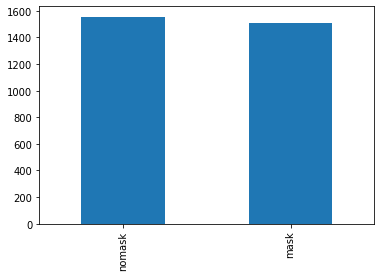

In [20]:
train_df['category'].value_counts().plot.bar()

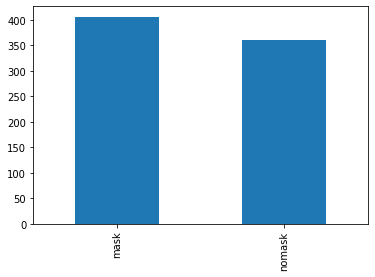

In [21]:
validate_df['category'].value_counts().plot.bar()

In [23]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [24]:
#Train Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
     train_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)

Found 3066 validated image filenames belonging to 2 classes.


In [25]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)


Found 767 validated image filenames belonging to 2 classes.


In [26]:
#See how our generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
)

Found 1 validated image filenames belonging to 1 classes.


In [28]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [29]:
# Early Stop
earlystop = EarlyStopping(patience=10)

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [31]:
callbacks= [earlystop, learning_rate_reduction]

In [32]:
# Fit model
epochs = 3 if FAST_RUN else 50

history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data= validation_generator,
    validation_steps= total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/50
204/204 [==============================] - 205s 1s/step - loss: 0.2933 - accuracy: 0.8994 - val_loss: 0.2800 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 2/50
204/204 [==============================] - 221s 1s/step - loss: 0.2827 - accuracy: 0.9007 - val_loss: 0.2744 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 3/50
204/204 [==============================] - 206s 1s/step - loss: 0.2591 - accuracy: 0.9076 - val_loss: 0.2423 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 4/50
204/204 [==============================] - 183s 897ms/step - loss: 0.2391 - accuracy: 0.9190 - val_loss: 0.2107 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 5/50
204/204 [==============================] - 87s 427ms/step - loss: 0.2217 - accuracy: 0.9233 - val_loss: 0.1992 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 6/50
204/204 [==============================] - 90s 441ms/step - loss: 0.2258 - accuracy: 0.9204 - val_loss: 0.1987 - val_accuracy: 0.9451 - lr: 0.0010
Epoch 7/50
204/204 [==============================] - 91s

204/204 [==============================] - 80s 394ms/step - loss: 0.1481 - accuracy: 0.9469 - val_loss: 0.1365 - val_accuracy: 0.9556 - lr: 1.0000e-05
Epoch 45/50
204/204 [==============================] - 80s 393ms/step - loss: 0.1527 - accuracy: 0.9459 - val_loss: 0.1368 - val_accuracy: 0.9556 - lr: 1.0000e-05
Epoch 46/50
204/204 [==============================] - 80s 393ms/step - loss: 0.1503 - accuracy: 0.9453 - val_loss: 0.1354 - val_accuracy: 0.9556 - lr: 1.0000e-05
Epoch 47/50
204/204 [==============================] - 80s 394ms/step - loss: 0.1558 - accuracy: 0.9436 - val_loss: 0.1358 - val_accuracy: 0.9556 - lr: 1.0000e-05
Epoch 48/50
204/204 [==============================] - 80s 393ms/step - loss: 0.1534 - accuracy: 0.9472 - val_loss: 0.1361 - val_accuracy: 0.9556 - lr: 1.0000e-05
Epoch 49/50
204/204 [==============================] - 80s 394ms/step - loss: 0.1453 - accuracy: 0.9489 - val_loss: 0.1362 - val_accuracy: 0.9556 - lr: 1.0000e-05
Epoch 50/50
204/204 [=============

In [33]:
model.save_weights("mask_model_ver3.h5")

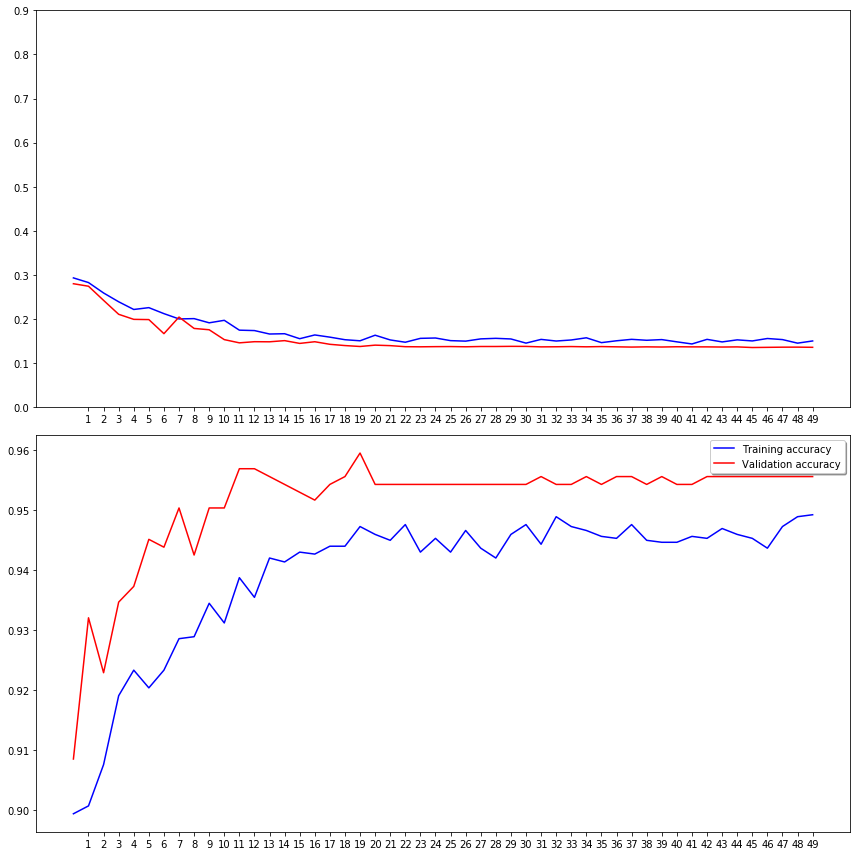

In [34]:
# Virtualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()